In [ ]:
# %pip install tensorflow

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# import warnings; warnings.simplefilter('ignore')

## Dataset

- Movies (Title, Genre, Date of release)
- users (Ratings given to movies, Date)

For the analysis we only kept movies- user's ratings.
We didn't explicitely use the genre of the movie and the dates, although we acknowledge/assume that
- (genre) is captured to a degree also in the data of the analysis.
- (dates) opinions change with time. Movies become classic others forgotten etc.

In [2]:
# ratings_df = pd.read_table('C:/Users/User/Documents/#M.L/2023/Final Project ML 2023 Recommender Systems/Datasets/ml-1m/ratings.dat', delimiter="::", engine='python', header=None, names=['userId','movieId','rating','timestamp'])
# movies_df  = pd.read_table('C:/Users/User/Documents/#M.L/2023/Final Project ML 2023 Recommender Systems/Datasets/ml-1m/movies.dat' , encoding='latin-1', delimiter="::", engine='python', header=None, names=['movieId','title','genres'])

# ratings_df = pd.read_csv('C:/Users/User/Documents/#M.L/2023/Final Project ML 2023 Recommender Systems/Datasets/ml-10m/ratings.dat',
#                          delimiter="::",engine='python', header=None, names=['userId', 'movieId', 'rating', 'timestamp'])

# movies_df  = pd.read_csv('C:/Users/User/Documents/#M.L/2023/Final Project ML 2023 Recommender Systems/Datasets/ml-10m/movies.dat',
#                          delimiter="::",engine='python', header=None, names=['movieId', 'title', 'genres'])

ratings_df = pd.read_csv('C:/Users/User/Documents/#M.L/2023/Final Project ML 2023 Recommender Systems/Datasets/ml-latest-small/ratings.csv')
movies_df  = pd.read_csv('C:/Users/User/Documents/#M.L/2023/Final Project ML 2023 Recommender Systems/Datasets/ml-latest-small/movies.csv')

Here we are scaling the dataset to be in $[0,1]$ range 

In [3]:
ratings_df.drop(columns=["timestamp"], inplace=True)
matrix_df = ratings_df.pivot(index='userId', columns='movieId', values='rating')

ratings_to_scale = matrix_df.iloc[:, 0:]

matrix_df.iloc[:, 0:] = ratings_to_scale/5

n_users = len(ratings_df.userId.unique())
n_movies = len(ratings_df.movieId.unique())
movie_titles = movies_df['title'].values.tolist()

#deliting unnessesary data (for memory reservation reasons)
del ratings_df
del movies_df

Filling the NaN values with $0.5$

In [4]:
null_filler = 0.5

full_index_values = matrix_df.index

full_mask = ~np.isnan(matrix_df)

full = matrix_df.fillna(null_filler)

full_np = full.to_numpy()

#deliting unnecessary data
del matrix_df
del full

---
---
$\DeclareMathOperator{\EX}{\mathbb{E}}$
 $\EX\limits_{_\text{over masked values} } [\big(y_{\text{true}}-y_{\text{pred}}\big)^2]$


In [5]:
from keras.losses import mean_squared_error
from keras import backend

def masked_mse(y_true, y_pred):
    mask = backend.cast(backend.not_equal(y_true, null_filler), backend.floatx())
    return mean_squared_error(y_true * mask, y_pred * mask)

## Define the model
Encoder: in[n_movies,?]-256ReLu-128ReLu-64linear_out  
Decoder: in[64,?]-128ReLu-256ReLu-(n_movies)linear_out

In [6]:
from keras.models import Model
from keras.layers import Input, Dense

# Create the autoencoder
# create the encoder
encoder_in = Input(shape=(full_np.shape[1],))
encoder1 = Dense(256, activation='relu')(encoder_in)
encoder2 = Dense(128, activation='relu')(encoder1)
encoder_out = Dense(64, activation='linear')(encoder2)
encoderM = Model(inputs=encoder_in, outputs=encoder_out)
encoderM.compile(optimizer='adam', loss=masked_mse)


# create the decoder
decoder_in = Input(shape=(64,))
decoder1 = Dense(128, activation='relu')(decoder_in)
decoder2 = Dense(256, activation='relu')(decoder1)
decoder_out = Dense(n_movies, activation='linear')(decoder2)
decoderM = Model(inputs=decoder_in, outputs=decoder_out)
decoderM.compile(optimizer='adam', loss=masked_mse)

#coompile
autoencoder = Model(inputs=encoder_in, outputs=decoderM(encoderM(encoder_in)))
autoencoder.compile(optimizer='adam', loss=masked_mse)


### 👀visual

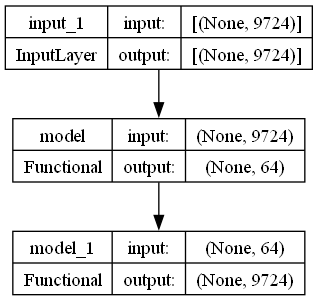

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model

plot_model(autoencoder, to_file='autoencoder_plot.png', show_shapes=True, show_layer_names=True)

## 🎓$\ $ Train the model  $\ $💪


In [8]:
autoencoder.fit(full_np, full_np, epochs=20, batch_size=32, shuffle=True)

Epoch 1/20

20/20 [==============================] - 5s 97ms/step - loss: 0.0032
Epoch 2/20
20/20 [==============================] - 2s 95ms/step - loss: 0.0010
Epoch 3/20
20/20 [==============================] - 2s 117ms/step - loss: 6.1769e-04
Epoch 4/20
20/20 [==============================] - 3s 135ms/step - loss: 5.7086e-04
Epoch 5/20
20/20 [==============================] - 2s 98ms/step - loss: 5.5662e-04
Epoch 6/20
20/20 [==============================] - 2s 91ms/step - loss: 5.6192e-04
Epoch 7/20
20/20 [==============================] - 2s 96ms/step - loss: 6.1046e-04
Epoch 8/20
20/20 [==============================] - 2s 107ms/step - loss: 6.2457e-04
Epoch 9/20
20/20 [==============================] - 2s 89ms/step - loss: 7.3347e-04
Epoch 10/20
20/20 [==============================] - 2s 98ms/step - loss: 5.9093e-04
Epoch 11/20
20/20 [==============================] - 2s 94ms/step - loss: 6.0860e-04
Epoch 12/20
20/20 [==============================] - 2s 100ms/step - loss: 5.9

In [ ]:
# autoencoder.save('autoencoder_10m_model.h5')

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



This function will be used in the case that we wont to use a model trained on a larger dataset. Meaning more movies this making the input the wrong size to be used. 



In [ ]:
def fill_missing_columns(data, expected_shape):
    current_shape = data.shape[1]

    if current_shape < expected_shape:
        # Calculate the number of missing columns
        missing_columns = expected_shape - current_shape

        # Create a matrix of zeros with the missing columns filled with 0.5
        filler_columns = np.full((data.shape[0], missing_columns), 0.5)

        # Concatenate the original data with the filler columns
        filled_data = np.concatenate((data, filler_columns), axis=1)

        return filled_data
    else:
        return data

In [ ]:
from keras.models import load_model

loaded_model = load_model('autoencoder_10m_3+3layers_model.h5', custom_objects={'masked_mse': masked_mse})

# in case of a diference in  data shape
# expected_shape = 10677
# filled_data = fill_missing_columns(full_np, expected_shape)
# predictions = loaded_model.predict(filled_data)

#  else we use the data directly
predictions = loaded_model.predict(full_np)

## Predictions

the moment of truth (?) ,or hopefully,

**good** **reccomendations**

In [11]:
predictions = autoencoder.predict(full_np)

20/20 [==============================] - 1s 19ms/step


Here we are transforming the dataset to have the names of the movies as the **Index**

In [12]:
predictions[full_mask] = np.nan # Make already wached movies prediction Nan
column_names = movie_titles[:(predictions.shape[1])]
newMovie_predictions_df = pd.DataFrame(data=predictions, columns=column_names)
newMovie_predictions_df.set_index(pd.Index(full_index_values), inplace=True)

## UI :
Enter the identifier of the user that you whant to get recomendations 

In [13]:
while True:
    try:
        userID = int(input("Enter userID: "))
        print("You entered:", userID)

        # Check if userID is in the list
        if userID in full_index_values:
            print("UserID is in the list.")
            break  # Break the loop if a valid ID is entered
        else:
            print("UserID is not in the list. Please try again.")

    except ValueError:
        print("Invalid input. Please enter a valid integer.")

You entered: 100
UserID is in the list.


In [15]:
top_n = 10  # Number of top recommendations

user_rest = newMovie_predictions_df.index.difference([userID])
newMovie_predictions_user = newMovie_predictions_df.drop(user_rest, axis=0, inplace=False).T
newMovie_predictions_user = newMovie_predictions_user.dropna()

newMovie_predictions_user.sort_values(by=userID, ascending=False)[:top_n]*5

userId,100
The Cloverfield Paradox (2018),7.107881
King Solomon's Mines (1950),7.059848
Ringu 0: Bâsudei (2000),7.043908
Taps (1981),6.913538
"10th Kingdom, The (2000)",6.887712
Porco Rosso (Crimson Pig) (Kurenai no buta) (1992),6.813084
"Oh, God! You Devil (1984)",6.806645
Snipes (2001),6.764593
Love Me If You Dare (Jeux d'enfants) (2003),6.710279
Breakin' (1984),6.683726
